In [2]:
# For processing the data
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline
sns.set_style("white") # set style for seaborn plots

# Machine learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer, log_loss
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
                              GradientBoostingClassifier, VotingClassifier, 
                              RandomForestClassifier, AdaBoostClassifier)
import xgboost as xgb

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("data.csv")
data = pd.DataFrame(data)
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
irrelevant = ["lon", "lat", "team_id", "team_name", "game_id", "game_event_id", "game_date"]
data = data.drop(columns=irrelevant)

In [5]:
tr = data.copy()
tr = tr.set_index("shot_id")

In [6]:
tr.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,167,72,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR
3,Jump Shot,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR
4,Jump Shot,Jump Shot,138,175,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,0,0,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR


In [7]:
tr_labels = data["shot_made_flag"]
tr_labels = tr_labels.dropna()
tr_labels

1        0.0
2        1.0
3        0.0
4        1.0
5        0.0
        ... 
30691    0.0
30692    0.0
30694    1.0
30695    0.0
30696    0.0
Name: shot_made_flag, Length: 25697, dtype: float64

In [8]:
tr_num = tr.select_dtypes(include='int64')
tr_num

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance
shot_id,,,,,,,
1,167,72,10,1,0,27,18
2,-157,0,10,1,0,22,15
3,-101,135,7,1,0,45,16
4,138,175,6,1,0,52,22
5,0,0,6,2,0,19,0
...,...,...,...,...,...,...,...
30693,1,48,6,4,1,5,4
30694,0,0,6,4,1,5,0
30695,-134,166,3,4,1,28,21


In [9]:
tr_cat = tr.select_dtypes(include='object')
tr_cat

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,
1,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR
3,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR
4,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR
...,...,...,...,...,...,...,...,...,...
30693,Jump Shot,Jump Shot,1999-00,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,LAL vs. IND,IND
30694,Tip Shot,Tip Shot,1999-00,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL vs. IND,IND
30695,Running Jump Shot,Jump Shot,1999-00,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL vs. IND,IND


In [10]:
le = LabelEncoder()

In [11]:
# Turning string data into numbers
tr["action_type"] = le.fit_transform(tr["action_type"])
tr["season"] = le.fit_transform(tr["season"])
tr["combined_shot_type"] = le.fit_transform(tr["combined_shot_type"])
tr["shot_type"] = le.fit_transform(tr["shot_type"])
tr["shot_zone_area"] = le.fit_transform(tr["shot_zone_area"])
tr["shot_zone_basic"] = le.fit_transform(tr["shot_zone_basic"])
tr["shot_zone_range"] = le.fit_transform(tr["shot_zone_range"])
tr["matchup"] = le.fit_transform(tr["matchup"])
tr["opponent"] = le.fit_transform(tr["opponent"])

In [12]:
tr.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
1,26,3,167,72,10,1,0,4,27,18,NaN,0,5,4,0,28,25
2,26,3,-157,0,10,1,0,4,22,15,0.0,0,3,4,2,28,25
3,26,3,-101,135,7,1,0,4,45,16,1.0,0,2,4,0,28,25
4,26,3,138,175,6,1,0,4,52,22,0.0,0,4,4,0,28,25
5,5,1,0,0,6,2,0,4,19,0,1.0,0,1,5,4,28,25


In [13]:
tr.dropna(subset=['shot_made_flag'], inplace=True)

In [14]:
tr.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
2,26,3,-157,0,10,1,0,4,22,15,0.0,0,3,4,2,28,25
3,26,3,-101,135,7,1,0,4,45,16,1.0,0,2,4,0,28,25
4,26,3,138,175,6,1,0,4,52,22,0.0,0,4,4,0,28,25
5,5,1,0,0,6,2,0,4,19,0,1.0,0,1,5,4,28,25
6,26,3,-145,-11,9,3,0,4,32,14,0.0,0,3,4,2,28,25


In [15]:
samples = tr.sample(25696, random_state=1)

In [16]:
samples.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
280,26,3,77,141,7,2,0,4,18,16,1.0,0,4,4,0,13,12
7668,27,4,0,0,4,4,0,9,24,0,0.0,0,1,5,4,17,16
6677,26,3,-126,79,4,5,0,8,34,14,0.0,0,3,4,2,73,32
12197,12,4,0,0,4,4,0,11,3,0,1.0,0,1,5,4,51,13
20590,26,3,151,69,4,3,0,16,38,16,0.0,0,5,4,0,8,7


In [17]:
samples.shape

(25696, 17)

In [18]:
X_amples = samples.drop(columns="shot_made_flag", axis = 1)
X_amples

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,
280,26,3,77,141,7,2,0,4,18,16,0,4,4,0,13,12
7668,27,4,0,0,4,4,0,9,24,0,0,1,5,4,17,16
6677,26,3,-126,79,4,5,0,8,34,14,0,3,4,2,73,32
12197,12,4,0,0,4,4,0,11,3,0,0,1,5,4,51,13
20590,26,3,151,69,4,3,0,16,38,16,0,5,4,0,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9319,27,4,23,2,2,1,0,9,48,2,0,1,5,4,2,2
13052,26,3,176,176,11,1,0,11,22,24,1,4,0,1,29,26
20583,26,3,195,118,3,2,0,16,16,22,0,5,4,0,8,7


In [19]:
X_amples.shape

(25696, 16)

In [20]:
y_amples = samples["shot_made_flag"]

In [21]:
y_amples.shape

(25696,)

Using TensorFlow backend.



nodes=1: 0.600
nodes=5: 0.604
nodes=10: 0.601
nodes=20: 0.626
nodes=50: 0.630


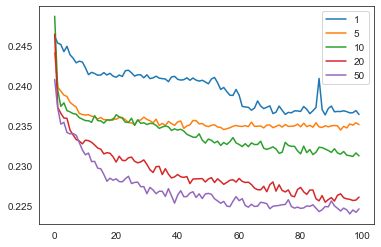

In [22]:
# study of mlp learning curves given different number of nodes for multi-class classification
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

features_train, features_test, target_train, target_test = train_test_split(X_amples, y_amples, test_size=0.5, random_state=0)

# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_nodes, features_train, target_train, features_test, target_test):
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=16, activation='sigmoid', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    # fit model on train set
    history = model.fit(features_train, target_train, epochs=100, verbose=0)
    # evaluate model on test set
    _, test_acc = model.evaluate(features_test, target_test, verbose=0)
    return history, test_acc

# evaluate model and plot learning curve with given number of nodes
num_nodes = [1, 5, 10, 20, 50]
for n_nodes in num_nodes:
    # evaluate model with a given number of nodes
    history, result = evaluate_model(n_nodes, features_train, target_train, features_test, target_test)
    # summarize final test set accuracy
    print('nodes=%d: %.3f' % (n_nodes, result))
    # plot learning curve
    pyplot.plot(history.history['loss'], label=str(n_nodes))
# show the plot
pyplot.legend()
pyplot.show()

layers=1: 0.627
layers=2: 0.616
layers=3: 0.620
layers=4: 0.614
layers=5: 0.621


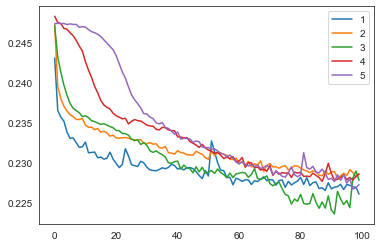

In [23]:
# fit model with given number of layers, returns test set accuracy
def evaluate_model(n_layers, features_train, target_train, features_test, target_test):
    # configure the model based on the data
    # define model
    model = Sequential()
    model.add(Dense(20, input_dim=16, activation='sigmoid', kernel_initializer='he_uniform'))
    for _ in range(1, n_layers):
        model.add(Dense(20, activation='sigmoid', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    # fit model
    history = model.fit(features_train, target_train, epochs=100, verbose=0)
    # evaluate model on test set
    _, test_acc = model.evaluate(features_test, target_test, verbose=0)
    return history, test_acc
 

# evaluate model and plot learning curve of model with given number of layers
all_history = list()
num_layers = [1, 2, 3, 4, 5]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, features_train, target_train, features_test, target_test)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    pyplot.plot(history.history['loss'], label=str(n_layers))
pyplot.legend()
pyplot.show()

In [24]:
tr = data.copy()
tr = tr.set_index("shot_id")

In [25]:
tr.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,167,72,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR
3,Jump Shot,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR
4,Jump Shot,Jump Shot,138,175,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,0,0,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR


In [26]:
tr_labels = data["shot_made_flag"]
tr_labels = tr_labels.dropna()
tr_labels

1        0.0
2        1.0
3        0.0
4        1.0
5        0.0
        ... 
30691    0.0
30692    0.0
30694    1.0
30695    0.0
30696    0.0
Name: shot_made_flag, Length: 25697, dtype: float64

In [27]:
tr_num = tr.select_dtypes(include='int64')
tr_num

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance
shot_id,,,,,,,
1,167,72,10,1,0,27,18
2,-157,0,10,1,0,22,15
3,-101,135,7,1,0,45,16
4,138,175,6,1,0,52,22
5,0,0,6,2,0,19,0
...,...,...,...,...,...,...,...
30693,1,48,6,4,1,5,4
30694,0,0,6,4,1,5,0
30695,-134,166,3,4,1,28,21


In [28]:
tr_cat = tr.select_dtypes(include='object')
tr_cat

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,
1,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR
3,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR
4,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR
...,...,...,...,...,...,...,...,...,...
30693,Jump Shot,Jump Shot,1999-00,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,LAL vs. IND,IND
30694,Tip Shot,Tip Shot,1999-00,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL vs. IND,IND
30695,Running Jump Shot,Jump Shot,1999-00,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL vs. IND,IND


In [29]:
le = LabelEncoder()

In [30]:
# Turning string data into numbers
tr["action_type"] = le.fit_transform(tr["action_type"])
tr["season"] = le.fit_transform(tr["season"])
tr["combined_shot_type"] = le.fit_transform(tr["combined_shot_type"])
tr["shot_type"] = le.fit_transform(tr["shot_type"])
tr["shot_zone_area"] = le.fit_transform(tr["shot_zone_area"])
tr["shot_zone_basic"] = le.fit_transform(tr["shot_zone_basic"])
tr["shot_zone_range"] = le.fit_transform(tr["shot_zone_range"])
tr["matchup"] = le.fit_transform(tr["matchup"])
tr["opponent"] = le.fit_transform(tr["opponent"])

In [31]:
tr.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
1,26,3,167,72,10,1,0,4,27,18,NaN,0,5,4,0,28,25
2,26,3,-157,0,10,1,0,4,22,15,0.0,0,3,4,2,28,25
3,26,3,-101,135,7,1,0,4,45,16,1.0,0,2,4,0,28,25
4,26,3,138,175,6,1,0,4,52,22,0.0,0,4,4,0,28,25
5,5,1,0,0,6,2,0,4,19,0,1.0,0,1,5,4,28,25


In [32]:
model = Sequential()
model.add(Dense(50, input_dim=16, activation='sigmoid', kernel_initializer='he_uniform'))
for _ in range(1, 1):
    model.add(Dense(50, activation='sigmoid', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=["accuracy"])

In [34]:
tr_test = tr
tr_train = tr

In [35]:
tr_test = tr_test[tr_test["shot_made_flag"].isnull()]
tr_train.dropna(subset=['shot_made_flag'], inplace=True)

X_train = tr_train.drop('shot_made_flag', axis=1)

In [36]:
X_test = tr_test.drop('shot_made_flag', axis=1)
X_test

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,
1,26,3,167,72,10,1,0,4,27,18,0,5,4,0,28,25
8,26,3,1,28,8,3,0,4,5,2,0,1,5,4,28,25
17,12,4,0,0,0,1,0,4,1,0,0,1,5,4,71,30
20,12,4,0,0,10,3,0,4,46,0,0,1,5,4,71,30
33,26,3,163,76,11,1,0,4,26,17,0,5,4,0,35,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30669,26,3,-23,222,7,4,1,3,27,22,0,1,4,0,12,11
30681,50,5,0,0,0,2,1,3,40,0,0,1,5,4,49,11
30683,41,3,-68,48,11,3,1,3,30,8,0,3,2,2,49,11


In [37]:
X_test.shape

(5000, 16)

In [38]:
train_attributes, test_attributes, train_target, test_target = train_test_split(X_train, tr_labels, test_size=0.20, random_state=1)

In [39]:
history = model.fit(train_attributes, train_target,
                     epochs=10000, verbose=0, batch_size=100,
                     validation_data=(train_attributes, train_target))

In [40]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

In [41]:
epoch_count = range(1, len(training_loss) + 1)
epoch_count

range(1, 10001)

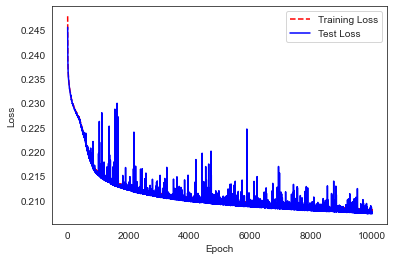

In [42]:
import matplotlib.pyplot as plt
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

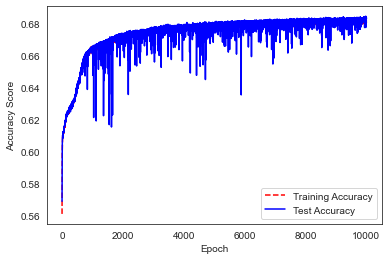

In [43]:
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show()

In [44]:
test_data = pd.read_csv("test_set.csv")
test_data = test_data.drop(test_data.columns[0], axis = 1)
test_data_id = test_data["shot_id"]
test_data_id = pd.DataFrame(test_data_id)

In [45]:
pred = model.predict(X_test)

In [46]:
pred

array([[0.35977867],
       [0.2896054 ],
       [0.70947814],
       ...,
       [0.63833904],
       [0.8281065 ],
       [0.6643333 ]], dtype=float32)

In [47]:
predictions = pd.DataFrame(pred)

In [48]:
test_data_id

,shot_id
0,1
1,8
2,17
3,20
4,33
...,...
4995,30669
4996,30681
4997,30683
4998,30687


In [49]:
submission_file = pd.concat([test_data_id, predictions], axis=1)
submission_file.columns = ["shot_id", "shot_made_flag"]

In [50]:
submission_file

,shot_id,shot_made_flag
0,1,0.359779
1,8,0.289605
2,17,0.709478
3,20,0.807853
4,33,0.376297
...,...,...
4995,30669,0.418106
4996,30681,0.695526
4997,30683,0.638339
4998,30687,0.828107


In [51]:
submission_file.to_csv('submission_file_NN_25696samples_50nodes_1layers_100batch.csv')